# Mixture density network: regression with uncertainty

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, LSTM, RepeatVector, TimeDistributed
from keras.optimizers import RMSprop, Adam

import edward as ed
from edward.models import Categorical, Normal, Beta, PointMass
from edward.models import Mixture, Categorical, Normal

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy import stats
from scipy.interpolate import interp1d
from scipy import optimize

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Instructions for updating:
Use the retry module or similar alternatives.


## Generate data

In [152]:
n_data = 2000
n_periods = 3
a = -0.5; b = 0.5
x_data = np.linspace(a, b, n_data)
y_data = np.sin(2*np.pi*n_periods*x_data/(b-a))+np.random.normal(loc=0, scale=0.2, size=n_data)
#y_data = np.sin(2*np.pi*n_periods*x_data/(b-a))+(x_data-a)/(b-a)*np.random.normal(loc=0, scale=0.2, size=n_data)
x_data = np.reshape(x_data, (n_data, 1))

n_pred = 2000
X_pred = np.reshape(np.linspace(1.25*a, 1.25*b, n_pred), (n_pred, 1))
y_pred = np.sin(2*np.pi*n_periods*X_pred/(b-a))
print('One period is {0} data points.'.format(n_data/n_periods))

One period is 666.6666666666666 data points.


No handles with labels found to put in legend.


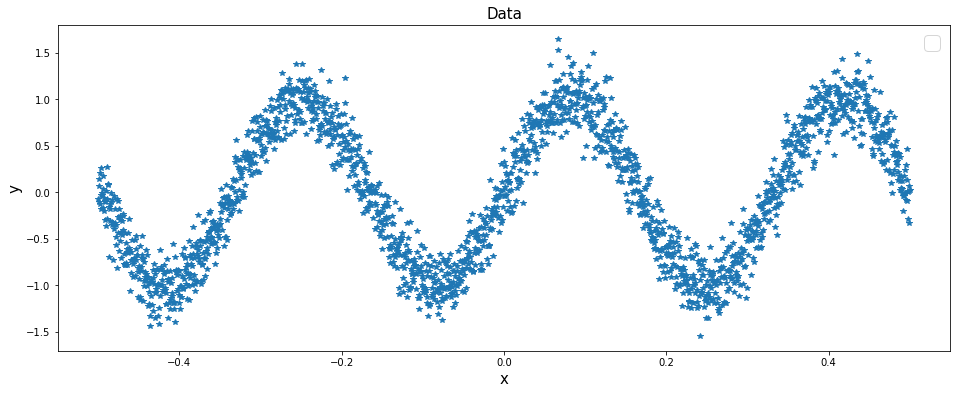

In [153]:
plt.figure(figsize=(16,6))
plt.plot(x_data, y_data, '*')
plt.title('Data', fontsize=15)
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

No handles with labels found to put in legend.


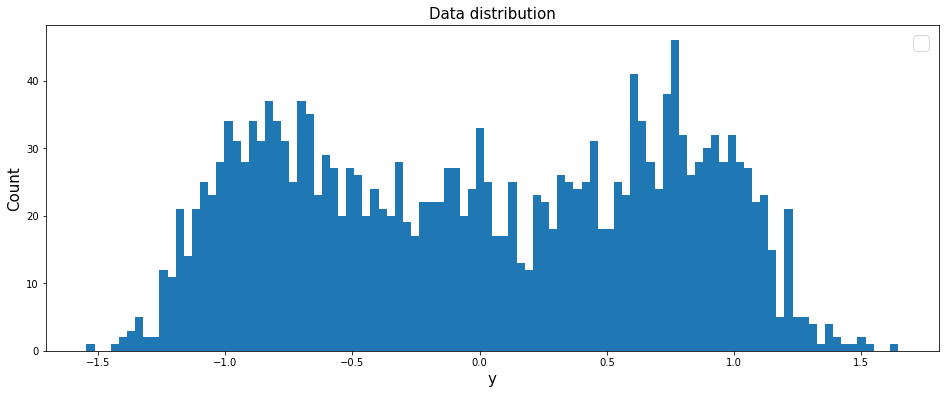

In [154]:
plt.figure(figsize=(16,6))
plt.hist(y_data, bins=100)
plt.title('Data distribution', fontsize=15)
plt.xlabel('y', fontsize=15)
plt.ylabel('Count', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Create supervised problem

In [155]:
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=test_size, shuffle=True)
print('Data points in train set: {0}.'.format(len(X_train)))
print('Data points in test set: {0}.'.format(len(X_test)))
print("Shape of features in training data: {}".format(X_train.shape))
print("Shape of output in training data: {}".format(y_train.shape))
print("Shape of features in test data: {}".format(X_test.shape))
print("Shape of output in test data: {}".format(y_test.shape))

Data points in train set: 1500.
Data points in test set: 500.
Shape of features in training data: (1500, 1)
Shape of output in training data: (1500,)
Shape of features in test data: (500, 1)
Shape of output in test data: (500,)


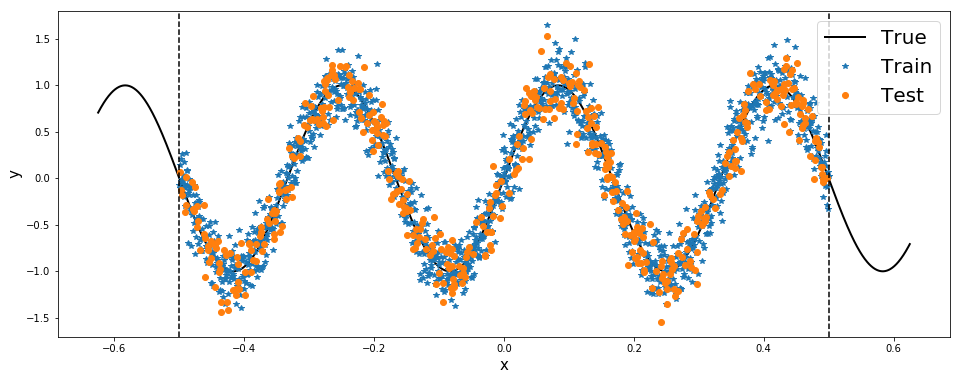

In [156]:
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', linewidth=2.0, label='True')
plt.plot(X_train, y_train, '*', label='Train')
plt.plot(X_test, y_test, 'o', label='Test')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)
plt.show()

## Feed forward neural network

### Build network

In [157]:
def build_ffnn():
    X = Input(shape=(1,))
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(X)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    y = Dense(units=1, activation='linear', kernel_initializer='glorot_uniform')(h)
    model = Model(inputs=X, outputs=y)
    
    return model

In [162]:
model = build_ffnn()

### Optimizer

In [163]:
def compile_ffnn(lr):
    adam = Adam(lr=lr, 
                beta_1=0.9, 
                beta_2=0.999, 
                epsilon=None, 
                decay=0.0, 
                amsgrad=False)
    model.compile(loss='mean_squared_error', optimizer=adam)
    
    return model

### Train model

In [164]:
mse_ffnn = np.array([]).reshape(0,3)
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [171]:
batch_size = 64 
lr = 1e-3
model = compile_ffnn(lr)
n_epoch_add = 100

n_epoch_final = n_epoch+n_epoch_add
history = model.fit(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=n_epoch_final, initial_epoch=n_epoch, batch_size=batch_size, verbose=1)
train_loss = np.append(train_loss, history.history['loss'])
test_loss = np.append(test_loss, history.history['val_loss'])
n_epoch = n_epoch_final

Train on 1500 samples, validate on 500 samples
Epoch 101/200
1500/1500 [==============================] - 1s 712us/step - loss: 0.0449 - val_loss: 0.0459
Epoch 102/200
1500/1500 [==============================] - 0s 36us/step - loss: 0.0439 - val_loss: 0.0457
Epoch 103/200
1500/1500 [==============================] - 0s 47us/step - loss: 0.0439 - val_loss: 0.0454
Epoch 104/200
1500/1500 [==============================] - 0s 34us/step - loss: 0.0437 - val_loss: 0.0440
Epoch 105/200
1500/1500 [==============================] - 0s 30us/step - loss: 0.0426 - val_loss: 0.0472
Epoch 106/200
1500/1500 [==============================] - 0s 31us/step - loss: 0.0442 - val_loss: 0.0474
Epoch 107/200
1500/1500 [==============================] - 0s 34us/step - loss: 0.0448 - val_loss: 0.0442
Epoch 108/200
1500/1500 [==============================] - 0s 32us/step - loss: 0.0429 - val_loss: 0.0456
Epoch 109/200
1500/1500 [==============================] - 0s 35us/step - loss: 0.0428 - val_loss: 0.048

Epoch 178/200
1500/1500 [==============================] - 0s 30us/step - loss: 0.0403 - val_loss: 0.0412
Epoch 179/200
1500/1500 [==============================] - 0s 32us/step - loss: 0.0398 - val_loss: 0.0401
Epoch 180/200
1500/1500 [==============================] - 0s 32us/step - loss: 0.0392 - val_loss: 0.0422
Epoch 181/200
1500/1500 [==============================] - 0s 30us/step - loss: 0.0395 - val_loss: 0.0437
Epoch 182/200
1500/1500 [==============================] - 0s 31us/step - loss: 0.0409 - val_loss: 0.0411
Epoch 183/200
1500/1500 [==============================] - 0s 31us/step - loss: 0.0397 - val_loss: 0.0417
Epoch 184/200
1500/1500 [==============================] - 0s 32us/step - loss: 0.0394 - val_loss: 0.0427
Epoch 185/200
1500/1500 [==============================] - 0s 31us/step - loss: 0.0401 - val_loss: 0.0427
Epoch 186/200
1500/1500 [==============================] - 0s 35us/step - loss: 0.0413 - val_loss: 0.0426
Epoch 187/200
1500/1500 [=====================

### Plot diagnostics

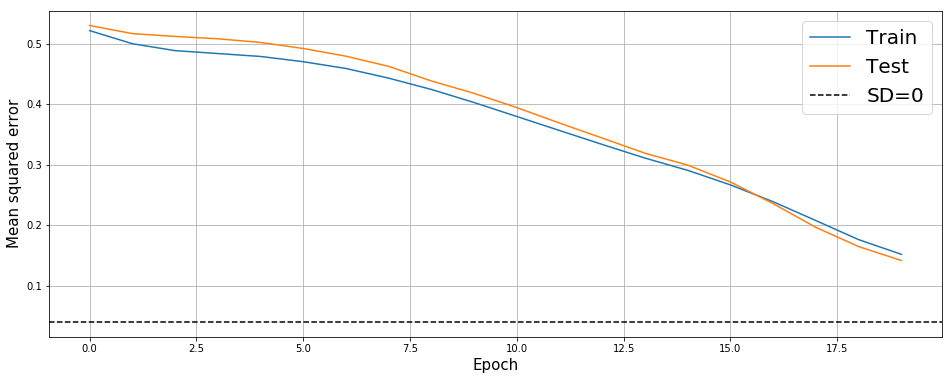

In [166]:
plt.figure(figsize=(16,6))
plt.plot(range(n_epoch), train_loss, label='Train')
plt.plot(range(n_epoch), test_loss, label='Test')
plt.axhline(0.2**2, linestyle='--', color='k', label='SD=0')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Mean squared error', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

### Plot predictions

##### After 20 epochs

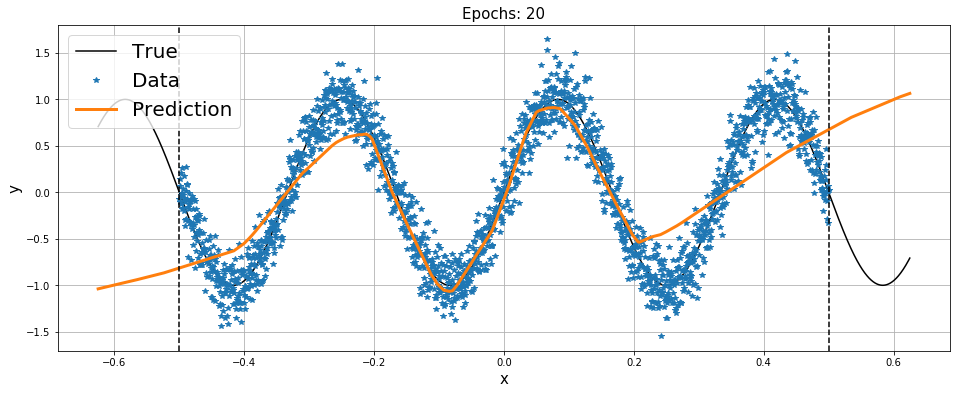

In [167]:
y_pred_model = model.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Epochs: 20', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

#### After 40 epochs

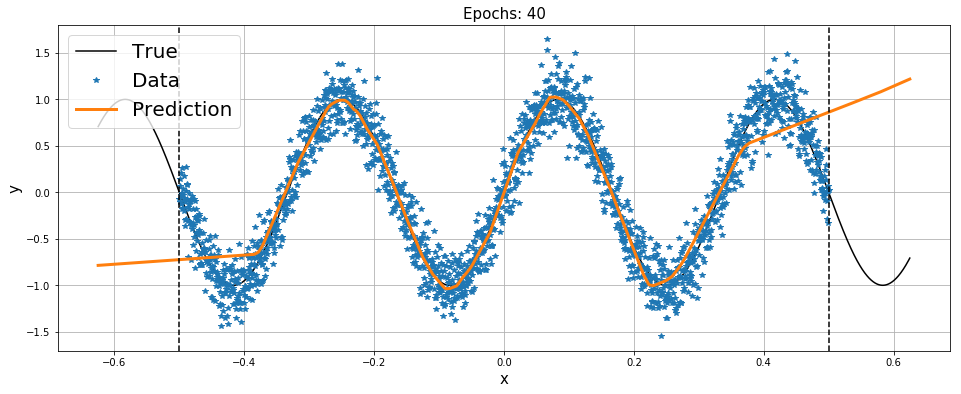

In [169]:
y_pred_model = model.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Epochs: 40', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

#### After 100 epochs

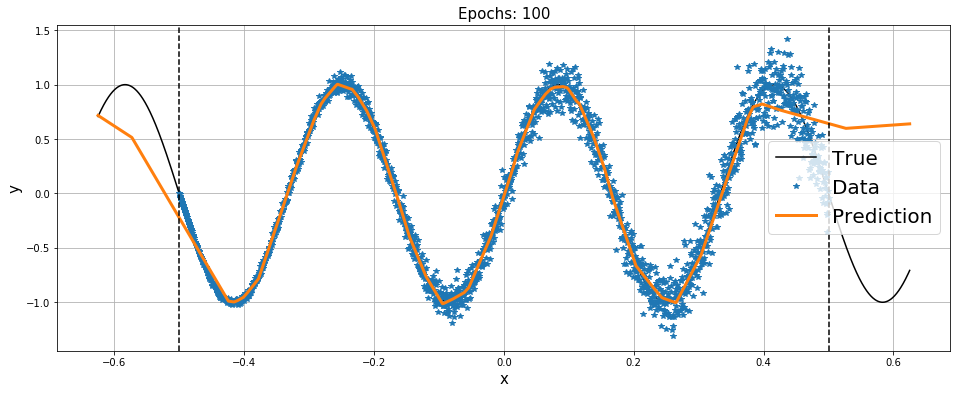

In [131]:
y_pred_model = model.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Epochs: 100', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

#### After 200 epochs

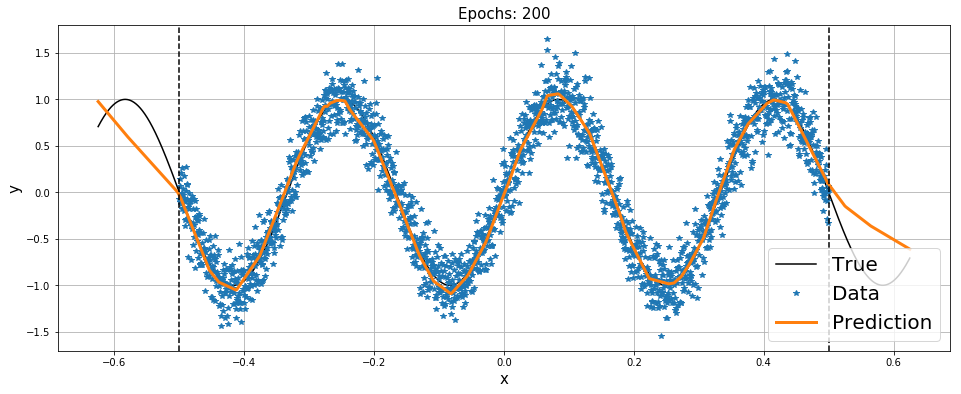

In [172]:
y_pred_model = model.predict(X_pred)
plt.figure(figsize=(16,6))
plt.plot(X_pred, y_pred, '-k', label='True')
plt.plot(x_data, y_data, '*', label='Data')
plt.plot(X_pred, y_pred_model, linewidth=3, label='Prediction')
plt.axvline(x=a, color='k', linestyle='--')
plt.axvline(x=b, color='k', linestyle='--')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.title('Epochs: 200', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

## Mixture density network

### Build network

In [133]:
def build_mdn(X, K):
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(X)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    h = Dense(units=16, activation='relu', kernel_initializer='glorot_uniform')(h)
    
    weights = Dense(units=K, activation='linear')(h)
    mus = Dense(units=K, activation='linear')(h)
    sigmas = Dense(units=K, activation=tf.exp)(h) # Could be softplus
    
    return weights, mus, sigmas

In [134]:
X_ph = tf.placeholder(tf.float32, [None, 1])
y_ph = tf.placeholder(tf.float32, [None])

In [135]:
K = 1    # Number of mixture components 
weights, mus, sigmas = build_mdn(X_ph, K)

cat = Categorical(logits=weights)
components = []
components.extend([Normal(loc=mu, scale=sigma) for mu, sigma 
                   in zip(tf.unstack(tf.transpose(mus)),tf.unstack(tf.transpose(sigmas)))])
y = ed.models.Mixture(cat=cat, components=components)

inference = ed.MAP(data={y: y_ph})

### Optimizer

In [136]:
lr_ph = tf.placeholder(tf.float32, shape=[], name='lr')
optim = 'Adam'
if optim == 'Adam':
    optimizer = tf.train.AdamOptimizer(learning_rate=lr_ph,
                                       beta1=0.9,
                                       beta2=0.999,
                                       epsilon=1e-08)
elif optim == 'RMSprop':
    optimizer = tf.train.RMSPropOptimizer(learning_rate=lr_ph,
                                          decay=0.9,
                                          epsilon=1e-10)
elif optim == 'Adagrad': 
    optimizer = tf.train.AdagradOptimizer(learning_rate=lr_ph,
                                          initial_accumulator_value=0.1,
                                          use_locking=False)
    
inference.initialize(optimizer=optimizer, var_list=tf.trainable_variables())

In [137]:
sess = ed.get_session()
tf.set_random_seed(1337)
tf.global_variables_initializer().run()

In [138]:
mse_mdn = np.array([]).reshape(0,3)
n_epoch = 0
train_loss = np.array([])
test_loss = np.array([])

In [139]:
batch_size = 64 
lrs = [0.0001]
for lr in lrs: 
    n_epoch_add = 10000
    train_loss = np.concatenate((train_loss,np.zeros(n_epoch_add)))
    test_loss = np.concatenate((test_loss,np.zeros(n_epoch_add)))
    inference.n_print = 100
    inference.progbar.target = n_epoch+n_epoch_add
    for i in range(n_epoch,n_epoch+n_epoch_add):
        info_dict = inference.update(feed_dict={X_ph: X_train, y_ph: y_train, lr_ph: lr})
        train_loss[i] = info_dict['loss']
        test_loss[i] = sess.run(inference.loss, feed_dict={X_ph: X_test, y_ph: y_test})
        inference.print_progress(info_dict)

    n_epoch = n_epoch+n_epoch_add

10000/10000 [100%] ██████████████████████████████ Elapsed: 29s | Loss: -1840.787


### Plot diagnostics

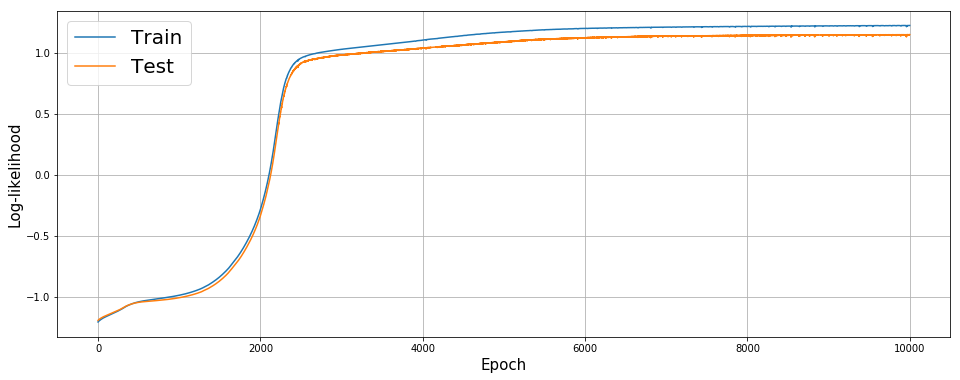

In [140]:
plt.figure(figsize=(16,6))
plt.plot(np.arange(n_epoch), -train_loss / len(X_train), label='Train')
plt.plot(np.arange(n_epoch), -test_loss / len(X_test), label='Test')
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Log-likelihood', fontsize=15)
plt.legend(fontsize=20)
plt.grid()
plt.show()

In [141]:
train_weights, train_mus, train_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_train})
test_weights, test_mus, test_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_test})
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})

### Plot predictions

In [142]:
class Mixture():
    
    def __init__(self, y, quantiles, pred_weights, pred_mus, pred_sigmas):
        # If x does not have high enough resolution. then this will not work. So make a check that enough points capture the pdf
        self.y = y
        self.quantiles = quantiles
        self.pred_weights = pred_weights
        self.pred_mus = pred_mus
        self.pred_sigmas = pred_sigmas
        
        self.mean()
        self.pdf()
        self.cdf()
        self.quantile()
    
    def mean(self):
        
        mean = self.pred_weights*self.pred_mus
        self.mean_mix = np.sum(mean, axis=1)
        
    def pdf(self):

        pdf = np.empty([len(self.y), self.pred_weights.shape[0], self.pred_weights.shape[1]])
        for i in range(self.pred_weights.shape[0]):
            for j in range(self.pred_weights.shape[1]):
                pdf[:,i,j] = self.pred_weights[i,j] * stats.norm.pdf(self.y, self.pred_mus[i,j], self.pred_sigmas[i,j])
        self.pdf_mix = np.sum(pdf, axis=2)
    
    def cdf(self):

        cdf = np.empty([len(self.y), self.pred_weights.shape[0], self.pred_weights.shape[1]])
        for i in range(self.pred_weights.shape[0]):
            for j in range(self.pred_weights.shape[1]):
                cdf[:,i,j] = self.pred_weights[i,j] * stats.norm.cdf(self.y, self.pred_mus[i,j], self.pred_sigmas[i,j])
        self.cdf_mix = np.sum(cdf, axis=2)
    
    def quantile(self):
        
        self.quantiles_mix = np.empty([self.pred_weights.shape[0], len(self.quantiles)])            
        for i in range(self.pred_weights.shape[0]):
            for k, q in enumerate(self.quantiles):
                
                f = interp1d(self.y, self.cdf_mix[:,i], kind='linear')
                self.quantiles_mix[i,k] = optimize.brentq(lambda y: f(y)-q, self.y[0], self.y[-1])


In [143]:
def plot_uncertainty(mixture, X_pred, y_pred):
    n_quantiles = len(mixture.quantiles)
    alpha = np.linspace(0.1,0.4,int(n_quantiles/2))
    fig, ax = plt.subplots(figsize=(16,6))
    for i in range(int(n_quantiles/2)):
        ax.fill_between(X_pred[:,0], mixture.quantiles_mix[:,i], mixture.quantiles_mix[:,-(1+i)], color='b', linewidth=0.0, alpha=alpha[i])

    ax.plot(X_pred, y_pred, '-k', label='True')
    plt.plot(x_data, y_data, '*', label='Data', alpha=0.3)
    ax.plot(X_pred, mixture.mean_mix, 'b', label='Prediction')
    ax.axvline(x=a, color='k', linestyle='--', alpha=0.5)
    ax.axvline(x=b, color='k', linestyle='--', alpha=0.5)
    plt.ylim([-2, 2])
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.legend(fontsize=20)

#### Plot predictions

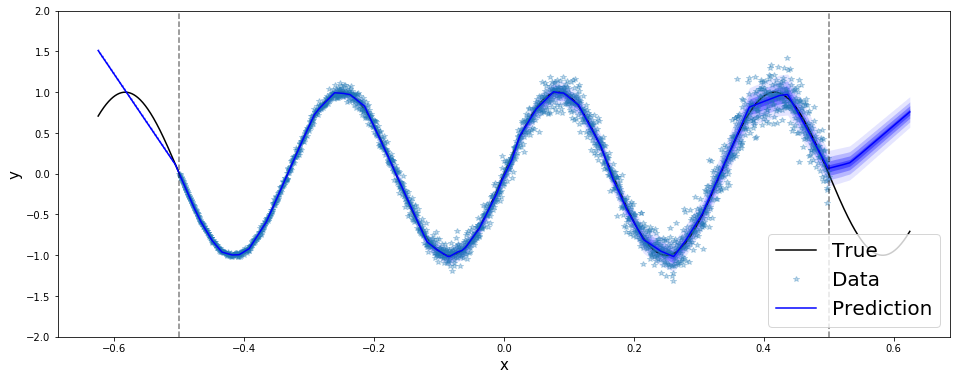

In [144]:
pred_weights, pred_mus, pred_sigmas = sess.run([tf.nn.softmax(weights), mus, sigmas], feed_dict={X_ph: X_pred})
y = np.linspace(-20, 20, 1000)
quantiles = np.arange(0.1,1,0.1)
mixture = Mixture(y, quantiles, pred_weights, pred_mus, pred_sigmas)
plot_uncertainty(mixture, X_pred, y_pred)

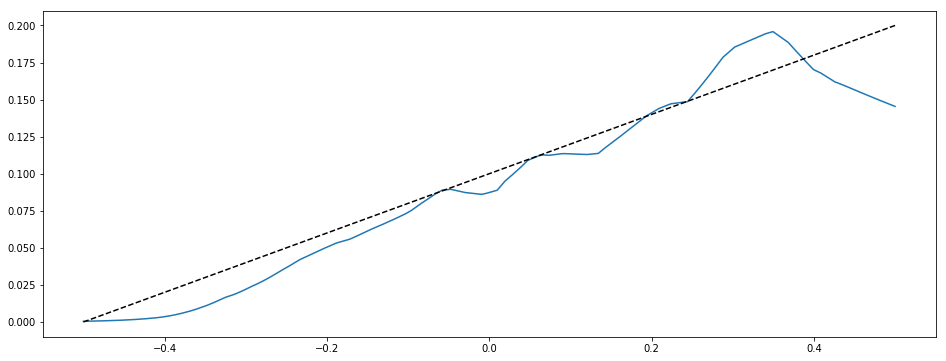

In [149]:
fig, ax = plt.subplots(figsize=(16,6))
ax.plot(x_data, pred_sigmas)
#ax.axhline(0.2, color='k', linestyle='--',)
plt.plot(x_data, 0.2*(x_data-a)/(b-a), 'k--',label='True')

### Plot samples

In [150]:
def sample_from_mixture(x, pred_weights, pred_mus, pred_sigmas, amount):

    samples = np.zeros((amount, 2))
    n_mix = len(pred_weights[0])
    to_choose_from = np.arange(n_mix)
    for j, (weights, mus, sigmas) in enumerate(zip(pred_weights, pred_mus, pred_sigmas)):
        index = np.random.choice(to_choose_from, p=weights)
        samples[j, 1] = np.random.normal(mus[index], sigmas[index], size=1)
        samples[j, 0] = x[j]
        if j == amount - 1:
            break
        
    return samples

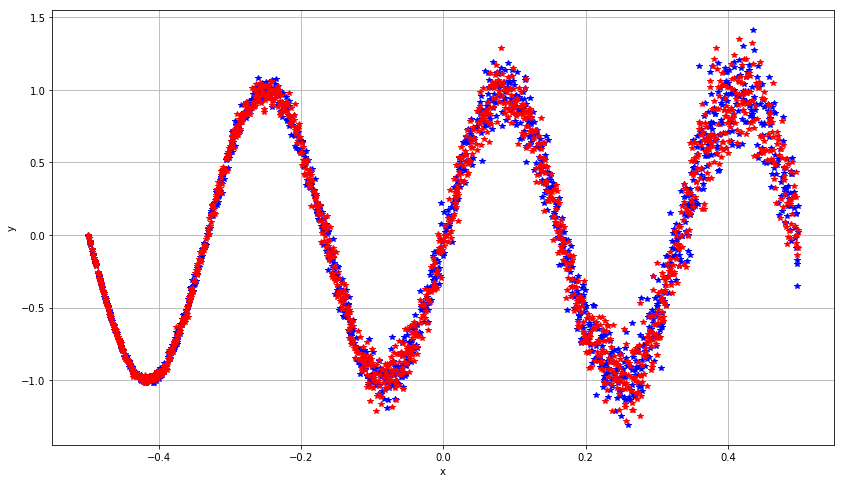

In [151]:
samples = sample_from_mixture(X_train, train_weights, train_mus, train_sigmas, amount=len(X_train))
plt.figure(figsize=(14,8))
plt.plot(X_train, y_train,'b*')
plt.plot(samples[:,0], samples[:,1],'r*')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()